In [1]:
pathmc="/eos/user/h/hsharma/PythiaFIles/dummySets/mc_events.csv"
pathdata="/eos/user/h/hsharma/PythiaFIles/dummySets/real_events.csv"


import numpy as np
import pandas as pd
import matplotlib as plt
# Set random seed for reproducibility
np.random.seed(42)

# Number of events
N_real = 10000  # Real dataset size
N_mc = 10000    # MC dataset size

# Generate "real" event data (from a slightly different true distribution)
real_pT = np.random.normal(loc=50, scale=10, size=N_real)  # Centered at 50 GeV
real_y = np.random.normal(loc=0, scale=1, size=N_real)      # Centered at 0
real_m = np.random.normal(loc=200, scale=20, size=N_real)   # Mass around 200 GeV

# Generate "MC" event data (with slight systematic shift)
mc_pT = np.random.normal(loc=52, scale=11, size=N_mc)  # Shifted mean + wider spread
mc_y = np.random.normal(loc=0.1, scale=1.1, size=N_mc)  # Small shift in rapidity
mc_m = np.random.normal(loc=195, scale=22, size=N_mc)   # Mass shifted down

# Create pandas DataFrames
real_data = pd.DataFrame({"pT": real_pT, "y": real_y, "m": real_m})
mc_data = pd.DataFrame({"pT": mc_pT, "y": mc_y, "m": mc_m})

# Save to CSV files
real_data_path = "/mnt/data/real_events.csv"
mc_data_path = "/mnt/data/mc_events.csv"

real_data.to_csv(pathmc, index=False)
mc_data.to_csv(pathdata, index=False)



array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

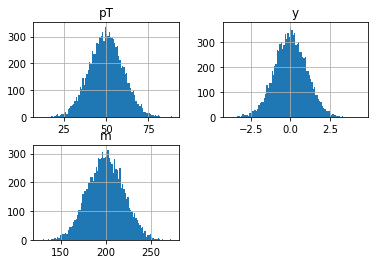

In [2]:
real_data[['pT','y','m']].hist(bins=100)

array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

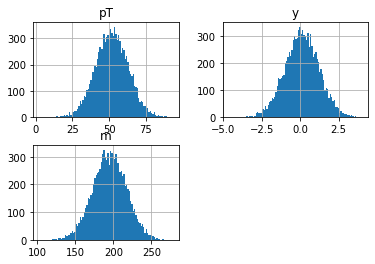

In [3]:
mc_data[['pT','y','m']].hist(bins=100)

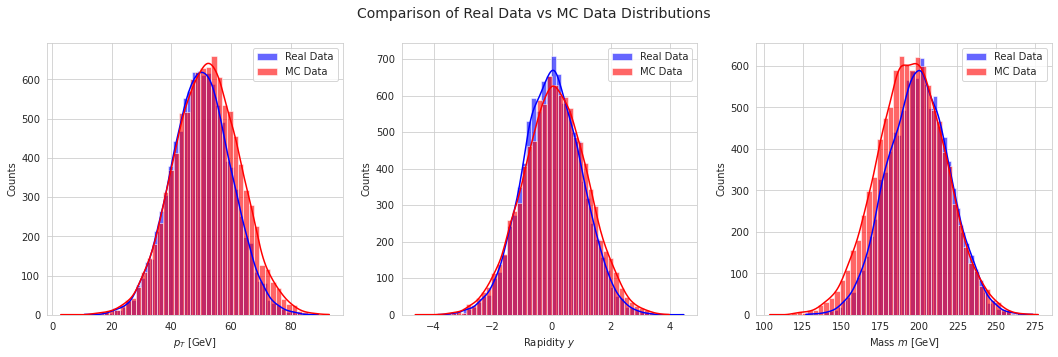

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define variable names and labels
variables = ["pT", "y", "m"]
labels = [r"$p_T$ [GeV]", r"Rapidity $y$", r"Mass $m$ [GeV]"]

# Plot distributions
for i, var in enumerate(variables):
    sns.histplot(real_data[var], bins=50, kde=True, color="blue", label="Real Data", ax=axes[i], alpha=0.6)
    sns.histplot(mc_data[var], bins=50, kde=True, color="red", label="MC Data", ax=axes[i], alpha=0.6)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Counts")
    axes[i].legend()

# Show the plots
plt.suptitle("Comparison of Real Data vs MC Data Distributions", fontsize=14)
plt.show()


In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Normalize data
scaler = StandardScaler()

# Fit on real data and transform both real and MC data using the same scaler
real_data_scaled = scaler.fit_transform(real_data)
real_data_scaled = pd.DataFrame(real_data_scaled, columns=real_data.columns)

mc_data_scaled = scaler.transform(mc_data)  # Apply the same transformation!
mc_data_scaled = pd.DataFrame(mc_data_scaled, columns=mc_data.columns)


In [6]:
import sys
sys.path.append('/eos/home-i02/h/hsharma/.local/lib/python3.9/site-packages')

from pzflow import Flow

import torch
from pzflow.bijectors import NeuralSplineCoupling
from torch.optim import Adam

# Define the normalizing flow with the desired bijector
flow = Flow(
    data_columns=["pT", "y", "m"], 
    bijector=NeuralSplineCoupling()
)

# Define the optimizer for the flow model
optimizer = Adam(flow.parameters(), lr=0.0001)

# Train the model with the custom optimizer
flow.train(real_data_scaled, epochs=500, optimizer=optimizer, batch_size=32, verbose=True)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


AttributeError: 'Flow' object has no attribute 'parameters'

In [ ]:
# Compute log probability densities for real and MC events
log_prob_real = flow.log_prob(real_data_scaled)
log_prob_mc = flow.log_prob(mc_data_scaled)

# Compute event weights
weights = np.exp(log_prob_real - log_prob_mc)

# Clip at the 99th percentile to remove extreme outliers
weight_clip = np.percentile(weights, 99)
weights = np.minimum(weights, weight_clip)

# Apply weights to MC events
mc_data["weights"] = weights

# Save reweighted MC events
mc_data.to_csv("reweighted_mc_events.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(weights, bins=100, log=True)
plt.xlabel("Weights")
plt.ylabel("Counts")
plt.title("Weight Distribution")
plt.show()

In [ ]:
plt.hist(mc_data["pT"], bins=50, weights=weights, alpha=0.5, label="Reweighted MC", density=True)
plt.hist(real_data["pT"], bins=50, alpha=0.5, label="Real Data", density=True)
plt.legend()
plt.xlabel("pT")
plt.ylabel("Density")
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

variables = ["pT", "y", "m"]
labels = [r"$p_T$ [GeV]", r"Rapidity $y$", r"Mass $m$ [GeV]"]

for i, var in enumerate(variables):
    #sns.histplot(real_data[var], bins=50, kde=True, color="blue", label="Real Data", ax=axes[i], alpha=0.6)
    #sns.histplot(mc_data[var], bins=50, kde=True, color="red", label="MC (Unweighted)", ax=axes[i], alpha=0.3)
#     sns.histplot(mc_data[var], bins=50, kde=True, weights=mc_data["weights"], color="green", label="MC (Weighted)", ax=axes[i], alpha=0.6)
    sns.histplot(data=mc_data, x=var, bins=50, kde=True, weights=mc_data["weights"], color="green", label="MC (Weighted)", ax=axes[i], alpha=0.6)

    
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Counts")
    axes[i].legend()

plt.suptitle("Effect of Reweighting on MC Distributions", fontsize=14)
plt.show()
